In [1]:
# Set some environment variables
import os
gpu_num = 0 # GPU to be used. Use "" to use the CPU
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Suppress some TF warnings
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    os.system("pip install sionna")
    import sionna

# Configure GPU
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Avoid warnings from TensorFlow
import warnings
tf.get_logger().setLevel('ERROR')
warnings.filterwarnings('ignore')

# Fix the seed for reproducible results
tf.random.set_seed(42)

E0000 00:00:1770576977.725879   61875 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770576977.731325   61875 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770576977.744855   61875 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770576977.744870   61875 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770576977.744871   61875 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770576977.744872   61875 computation_placer.cc:177] computation placer already registered. Please check linka

In [2]:
# Import Sionna RT components
from sionna.rt import load_scene, PlanarArray, Transmitter, Receiver, Camera, PathSolver, RadioMapSolver, subcarrier_frequencies

# For link-level simulations
from sionna.phy import mapping,ofdm,utils
from sionna.phy.channel import cir_to_ofdm_channel, subcarrier_frequencies, OFDMChannel, ApplyOFDMChannel, CIRDataset, AWGN
from sionna.phy.nr import PUSCHConfig, PUSCHTransmitter, PUSCHReceiver
from sionna.phy.utils import compute_ber, ebnodb2no, PlotBER
from sionna.phy.ofdm import KBestDetector, LinearDetector, ResourceGrid
from sionna.phy.mapping import Constellation, Mapper, Demapper
from sionna.phy.fec.polar import PolarEncoder, Polar5GEncoder, PolarSCLDecoder, Polar5GDecoder, PolarSCDecoder
from sionna.phy.fec.ldpc import LDPC5GEncoder, LDPC5GDecoder
from sionna.phy.fec.polar.utils import generate_5g_ranking, generate_rm_code
from sionna.phy.fec.conv import ConvEncoder, ViterbiDecoder, BCJRDecoder
from sionna.phy.fec.turbo import TurboEncoder, TurboDecoder
from sionna.phy.fec.linear import OSDecoder
from sionna.phy.mapping import BinarySource
from sionna.phy.utils.metrics import  count_block_errors
from sionna.phy.mimo import StreamManagement

import scipy.special as sp
import scipy.stats as stats

# For the implementation of the Keras models
from tensorflow.keras import Model
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

In [3]:
#scene = load_scene(sionna.rt.scene.munich, merge_shapes=True) # Merge /home/minhaj/weeks_hallshapes to speed-up computations
scene = load_scene('/home/native/project/weeks_hall_final/weeks_hall_final.xml', merge_shapes=False)
#scene.objects
#scene.radio_materials

# Configure antenna array for all transmitters
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0,
                             horizontal_spacing=0,
                             pattern="iso",
                             polarization="H")

# Configure antenna array for all receivers
scene.rx_array = PlanarArray(num_rows=1,
                             num_cols=1, 
                             vertical_spacing=0,
                             horizontal_spacing=0,
                             pattern="iso", 
                             polarization="H")


# Create transmitter
tx = Transmitter(name="tx",
                 position=[-6,6.2,3],
                 display_radius=0.5)

# Add transmitter instance to scene
scene.add(tx)

# Create a receiver
rx = Receiver(name="rx",
              position=[-1.4,2.8,1.1],
              display_radius=0.5)

# Add receiver instance to scene
scene.add(rx)

#tx.look_at(rx) # Transmitter points towards receiver
# Pick a size that fits your cell
scene.preview();   # e.g., 480x360, 600x400, 720x480


In [4]:
scene.frequency = 3.5e9 # in Hz; implicitly updates RadioMaterials
scene.synthetic_array = True # If set to False, ray tracing will be done per antenna element (slower for large arrays)

In [5]:
# Instantiate a path solver
# The same path solver can be used with multiple scenes
p_solver  = PathSolver()

# Compute propagation paths
paths = p_solver(scene=scene,
                 max_depth=2,
                 los=True,
                 specular_reflection=True,
                 diffuse_reflection=True,
                 refraction=True,
                 synthetic_array=True,
                 seed=41)

Shape of a:  (1, 1, 1, 1, 24, 1)
Shape of tau:  (1, 1, 24)


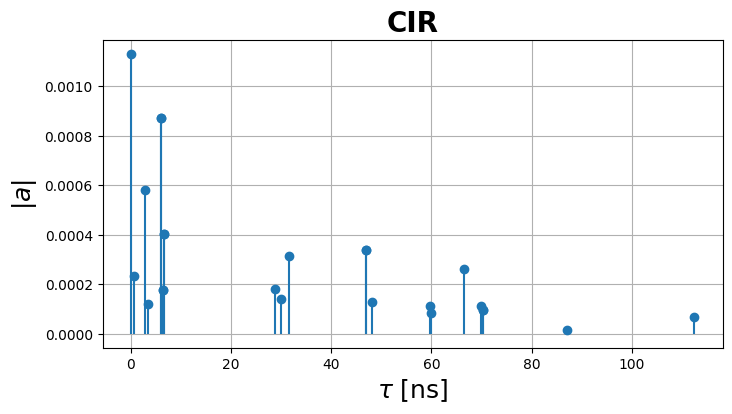

In [7]:
a, tau = paths.cir(normalize_delays=True,num_time_steps=1, out_type="numpy")

# Shape: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths, num_time_steps]
print("Shape of a: ", a.shape)
# Shape: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths]
print("Shape of tau: ", tau.shape)

t = tau[0,0,:]/1e-9 # Scale to ns
a_abs = np.abs(a)[0,0,0,0,:,0]
a_max = np.max(a_abs)

# (re-)plot your CIR
fig, ax = plt.subplots(figsize=(8,4))
ax.stem(t, a_abs, basefmt=" ")
ax.set_title("CIR", fontsize=20, fontweight="bold")
ax.set_xlabel(r"$\tau$ [ns]", fontsize=18)
ax.set_ylabel(r"$|a|$",     fontsize=18)
ax.grid(True)